In [1]:
import dataLoader as loader
import HDDMmodelMaker as ddm
import pandas as pd
import time
import matplotlib.pyplot as plt
import hddm
import random
import scipy.stats as st
import numpy as np
import seaborn as sns
import pymc as mc
import random 
import kabuki
from mpl_toolkits.mplot3d import Axes3D
import statsmodels
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial import distance

/Users/eladiomontero/opt/anaconda3/envs/decTimesEnv/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [2]:
data = hddm.load_csv("data_actions.csv")

In [3]:
def actionChange(actions1, actions2, user1, user2, rt):
    if len(actions1) != len(actions2): return "Lenghts mismatch" #Raise exception
    rounds = len(actions1)
    prev1 = ""
    prev2 = ""
    switch_events = pd.DataFrame(columns=["type", "lag", "subject", "round", "rt"])
    lag = 0
    for r in range(0, rounds):
        if r ==0:
            prev1 = actions1[r]
            prev2 = actions2[r]
            lag += 1
            continue
        elif actions1[r] != prev1:
            switch_events = switch_events.append(
                {"context": prev2, "type": "%s%s" % (prev1, actions1[r]),
                 "lag": lag, "subject": user1, "round": r + 1, "rt": rt[r]}, ignore_index=True)
            lag = 0
        if actions2[r] == prev2:
            lag += 1
        else: lag = 1
        prev1 = actions1[r]
        prev2 = actions2[r]
    return switch_events

In [4]:
def actionCounts(actions, user):
    prosocial = ['CCC', 'CDC', '00C', 'DDC', 'DCC']
    proself = ['DDD', 'DCD', '00D', 'CCD', 'CDD']
    rating = 0
    act_df = {'user':user,'00D':0,'00C':0,'DCD':0,'CDC':0,'CCC':0,'CDD':0,'CCD':0,'DDC':0,'DCC':0,'DDD':0, 'type':""}
    for a in actions:
        act_df[a] = act_df[a] + 1
        if a in prosocial:
            rating = rating + 1
        else: rating = rating - 1
    if rating >= 0: act_df["type"] = "Pro-social"
    else: act_df["type"] = "Pro-self"
    return act_df

In [5]:
switches = pd.DataFrame()
actions = pd.DataFrame()
for t in data.treatment.unique():
    t_df = data.loc[(data.treatment == t)]
    users = t_df.player.unique()
    switchesT = pd.DataFrame()
    actionsT = pd.DataFrame()
    for u in users:
        df = t_df.loc[t_df.player == u]
        df = df.sort_values(by = "round", ascending = True)
        opp = str(df.opponent.unique())
        acc1 = df.action_player.values
        acc2 = df.action_opponent.values
        rt = df["rt"].values
        switchesT = switchesT.append(actionChange(acc1, acc2, u, opp, rt))
        actionsT = actionsT.append(actionCounts(df.actions, u), ignore_index=True)
    switchesT["treatment"] = t
    actionsT["treatment"] = t
    switches = switches.append(switchesT, ignore_index = True)
    actions = actions.append(actionsT, ignore_index = True)

/Users/eladiomontero/opt/anaconda3/envs/decTimesEnv/lib/python2.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [6]:
data_svo = pd.merge(data, actions[["type", "user"]], left_on = "player", right_on = "user")
data_svo.opponent = data_svo['opponent'].str.strip("['']")

# Changing

In [7]:
chang = data_svo[data_svo.treatment == "changing"]
chang["type"].value_counts()

Pro-self      7500
Pro-social    2100
Name: type, dtype: int64

In [8]:
# Split fix experiment players, 96 total, 67 training, 29 testing
random.seed(1234)
subjects_chang = list(chang.player.unique())
sample_subj = random.sample(subjects_chang, int(len(subjects_chang) * 0.7))
train_chang = chang.loc[chang.player.isin(sample_subj)]
test_chang = chang.loc[~chang.player.isin(sample_subj)]

In [9]:
train_chang

,Unnamed: 0,round,player,action_player,opponent,action_opponent,payoff,rt,session,treatment,actions,response,abs_time,type,user
3200,3200,1,s5m20_usuario1,D,s5m20_usuario12,D,1,-6.678,s5m20,changing,00D,0,6.678,Pro-self,s5m20_usuario1
3201,3218,2,s5m20_usuario1,C,s5m20_usuario5,C,3,12.111,s5m20,changing,DDC,1,12.111,Pro-self,s5m20_usuario1
3202,3236,3,s5m20_usuario1,C,s5m20_usuario10,C,3,11.379,s5m20,changing,CCC,1,11.379,Pro-self,s5m20_usuario1
3203,3254,4,s5m20_usuario1,C,s5m20_usuario15,C,3,8.171,s5m20,changing,CCC,1,8.171,Pro-self,s5m20_usuario1
3204,3272,5,s5m20_usuario1,C,s5m20_usuario16,C,3,3.494,s5m20,changing,CCC,1,3.494,Pro-self,s5m20_usuario1
3205,3290,6,s5m20_usuario1,D,s5m20_usuario12,D,1,-2.094,s5m20,changing,CCD,0,2.094,Pro-self,s5m20_usuario1
3206,3308,7,s5m20_usuario1,D,s5m20_usuario10,D,1,-6.941,s5m20,changing,DDD,0,6.941,Pro-self,s5m20_usuario1
3207,3326,8,s5m20_usuario1,C,s5m20_usuario13,C,3,1.986,s5m20,changing,DDC,1,1.986,Pro-self,s5m20_usuario1
3208,3344,9,s5m20_usuario1,C,s5m20_usuario15,C,3,1.965,s5m20,changing,CCC,1,1.965,Pro-self,s5m20_usuario1
3209,3362,10,s5m20_usuario1,C,s5m20_usuario15,C,3,1.722,s5m20,changing,CCC,1,1.722,Pro-self,s5m20_usuario1


In [10]:
actions

,00C,00D,CCC,CCD,CDC,CDD,DCC,DCD,DDC,DDD,type,user,treatment
0,0.0,1.0,69.0,9.0,1.0,2.0,9.0,1.0,3.0,5.0,Pro-social,s3m7_usuario9,weak
1,1.0,0.0,74.0,4.0,9.0,1.0,2.0,1.0,3.0,5.0,Pro-social,s3m7_usuario18,weak
2,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pro-social,s3m7_usuario7,weak
3,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pro-social,s3m7_usuario10,weak
4,1.0,0.0,97.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,Pro-social,s3m7_usuario13,weak
5,1.0,0.0,98.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Pro-social,s3m7_usuario5,weak
6,0.0,1.0,93.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0,Pro-social,s3m7_usuario15,weak
7,1.0,0.0,93.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,Pro-social,s3m7_usuario16,weak
8,0.0,1.0,86.0,2.0,1.0,1.0,3.0,3.0,1.0,2.0,Pro-social,s3m7_usuario12,weak
9,1.0,0.0,88.0,0.0,3.0,3.0,1.0,1.0,2.0,1.0,Pro-social,s3m7_usuario6,weak


In [11]:
def print_traces (svo, param, context = ""):
    if context == "":
        df = pd.read_csv("./outputs/%s_svo.csv" % (svo))
    else: df = pd.read_csv("./outputs/%s_%s_svo.csv" % (context, svo))
    
    return df[param]

In [12]:
train_chang["type"].value_counts()

Pro-self      5200
Pro-social    1500
Name: type, dtype: int64

In [13]:
#Model with subjects 

train_fix_sub = train_fix
train_fix_sub["subj_idx"] = train_fix_sub.player
modeler = ddm.HDDMmodelMaker()
model_soc_s1 = modeler.fit_model(train_fix_sub.loc[(train_fix_sub["type"] == "Pro-social")], 5000, 200)
model_sel_s1 = modeler.fit_model(train_fix_sub.loc[(train_fix_sub["type"] == "Pro-self")], 5000, 200)

NameError: name 'train_fix' is not defined

In [14]:
modeler = ddm.HDDMmodelMaker()
models_sel_s2 = []
models_soc_s2 = []
df_soc = train_chang.loc[(train_chang["type"] == "Pro-social")]
df_sel = train_chang.loc[(train_chang["type"] == "Pro-self")]
for s in df_soc.player.unique():
    model_soc_s2 = modeler.fit_model(df_soc.loc[(df_soc["player"] == s)], 5000, 200)
    models_soc_s2.append(model_soc_s2)

for s in df_sel.player.unique():
    model_sel_s2 = modeler.fit_model(df_sel.loc[(df_sel["player"] == s)], 5000, 200)
    models_sel_s2.append(model_sel_s2)

 [-----------------100%-----------------] 5000 of 5000 complete in 6.2 sec

In [15]:
stats_soc_s2 = pd.DataFrame()
stats_sel_s2 = pd.DataFrame()
for m in models_soc_s2:
    stats = modeler.get_stats(m)
    stats["type"] = "Pro-social"
    stats_soc_s2 = stats_soc_s2.append(stats, ignore_index = True)
for m in models_sel_s2:
    stats = modeler.get_stats(m)
    stats["type"] = "Pro-self"
    stats_sel_s2 = stats_sel_s2.append(stats, ignore_index = True)
stats_sel_s2

,parameter,mean,std,2.5q,25q,50q,75q,97.5q,mc err,type
0,a,2.94891,0.137436,2.69018,2.85297,2.94349,3.04027,3.2213,0.00323676,Pro-self
1,v,0.0130156,0.0781004,-0.13652,-0.0413148,0.0133624,0.0668916,0.164868,0.00154922,Pro-self
2,t,0.591759,0.071077,0.433497,0.54781,0.598105,0.642588,0.710768,0.00169457,Pro-self
3,z,0.470678,0.0315148,0.408318,0.449588,0.47072,0.490745,0.533562,0.000651158,Pro-self
4,a,3.82567,0.190827,3.46924,3.69553,3.81857,3.94794,4.2242,0.00371124,Pro-self
5,v,-0.160619,0.0709273,-0.296656,-0.210422,-0.161748,-0.11316,-0.0187046,0.00146806,Pro-self
6,t,0.35482,0.0501164,0.236319,0.326059,0.36277,0.391757,0.430928,0.00126506,Pro-self
7,z,0.297886,0.0306455,0.24216,0.275894,0.296445,0.318529,0.361508,0.000762835,Pro-self
8,a,4.65601,0.426313,3.92671,4.35609,4.6134,4.92565,5.58745,0.0132255,Pro-self
9,v,-0.510842,0.0847627,-0.681374,-0.566791,-0.509686,-0.453644,-0.34745,0.00220318,Pro-self


In [16]:
#Model without subjects
modeler = ddm.HDDMmodelMaker()
model_soc_m1 = modeler.fit_model(train_chang.loc[(train_chang["type"] == "Pro-social")], 5000, 200)
model_sel_m1 = modeler.fit_model(train_chang.loc[(train_chang["type"] == "Pro-self")], 5000, 200)

 [-----------------100%-----------------] 5000 of 5000 complete in 100.1 sec

In [17]:
#Model without subjects
modeler = ddm.HDDMmodelMaker()
models_sel_m2 = []
models_soc_m2 = []
for r in range(1, 11):
    print("%d - %d" % ((r - 1) * 10, (r * 10)))
    model_soc_m2 = modeler.fit_model(train_chang.loc[(train_chang["type"] == "Pro-social") & (train_chang["round"] <= (r * 10)) & (train_chang["round"] > ((r - 1) * 10))], 5000, 200)
    model_sel_m2 = modeler.fit_model(train_chang.loc[(train_chang["type"] == "Pro-self") & (train_chang["round"] <= (r * 10)) & (train_chang["round"] > ((r - 1) * 10))], 5000, 200)
    models_sel_m2.append(model_sel_m2)
    models_soc_m2.append(model_soc_m2)

0 - 10
 [-----------------100%-----------------] 5000 of 5000 complete in 16.4 sec10 - 20
 [-----------------100%-----------------] 5000 of 5000 complete in 13.8 sec20 - 30
 [-----------------100%-----------------] 5000 of 5000 complete in 13.5 sec30 - 40
 [-----------------100%-----------------] 5000 of 5000 complete in 12.6 sec40 - 50
 [-----------------100%-----------------] 5000 of 5000 complete in 12.6 sec50 - 60
 [-----------------100%-----------------] 5000 of 5000 complete in 12.1 sec60 - 70
 [-----------------100%-----------------] 5000 of 5000 complete in 12.7 sec70 - 80
 [-----------------100%-----------------] 5000 of 5000 complete in 11.5 sec80 - 90
 [-----------------100%-----------------] 5000 of 5000 complete in 11.7 sec90 - 100
 [-----------------100%-----------------] 5000 of 5000 complete in 11.5 sec

In [18]:
#Model without subjects
modeler = ddm.HDDMmodelMaker()
models_sel_m3 = []
models_soc_m3 = []
for r in range(1, 11):
    print("%d - %d" % (0, (r * 10)))
    model_soc_m3 = modeler.fit_model(train_chang.loc[(train_chang["type"] == "Pro-social") & (train_chang["round"] <= (r * 10))], 5000, 200)
    model_sel_m3 = modeler.fit_model(train_chang.loc[(train_chang["type"] == "Pro-self") & (train_chang["round"] <= (r * 10))], 5000, 200)
    models_sel_m3.append(model_sel_m3)
    models_soc_m3.append(model_soc_m3)

0 - 10
 [-----------------100%-----------------] 5000 of 5000 complete in 16.0 sec0 - 20
 [-----------------100%-----------------] 5000 of 5000 complete in 24.4 sec0 - 30
 [-----------------100%-----------------] 5000 of 5000 complete in 32.8 sec0 - 40
 [-----------------100%-----------------] 5000 of 5000 complete in 41.2 sec0 - 50
 [-----------------100%-----------------] 5000 of 5000 complete in 50.0 sec0 - 60
 [-----------------100%-----------------] 5000 of 5000 complete in 71.0 sec0 - 70
 [-----------------100%-----------------] 5000 of 5000 complete in 93.1 sec0 - 80
 [-----------------100%-----------------] 5000 of 5000 complete in 82.3 sec0 - 90
 [-----------------100%-----------------] 5000 of 5000 complete in 90.5 sec0 - 100
 [-----------------100%-----------------] 5000 of 5000 complete in 100.4 sec

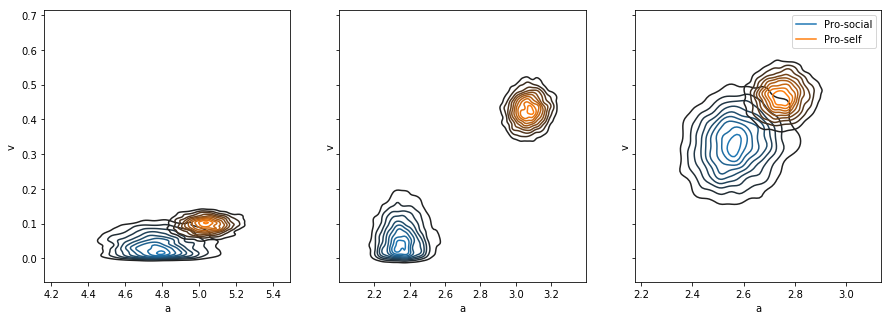

In [19]:
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharey = True)
count = 0
for r in [0,5,9]:
    sns.kdeplot(models_soc_m2[r].get_traces()["a"], np.abs(models_soc_m2[r].get_traces()["v"]), label = "Pro-social", ax=axes[count])
    sns.kdeplot(models_sel_m2[r].get_traces()["a"], np.abs(models_sel_m2[r].get_traces()["v"]),  label = "Pro-self", ax=axes[count])
    count = count + 1
plt.legend()

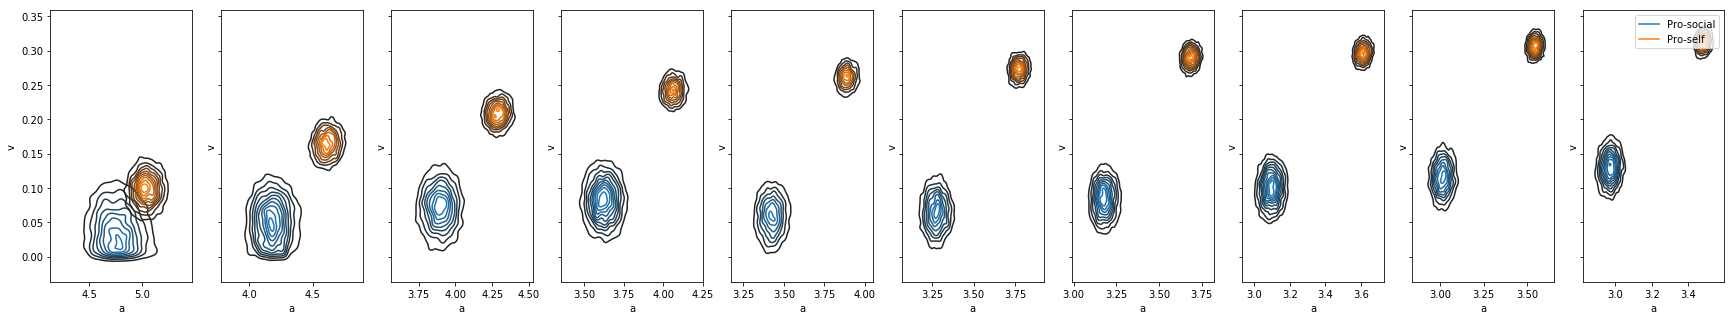

In [20]:
f, axes = plt.subplots(1, 10, figsize=(30, 5), sharey = True)
for r in range(0,10):
    sns.kdeplot(models_soc_m3[r].get_traces()["a"], np.abs(models_soc_m3[r].get_traces()["v"]), label = "Pro-social", ax=axes[r])
    sns.kdeplot(models_sel_m3[r].get_traces()["a"], np.abs(models_sel_m3[r].get_traces()["v"]),  label = "Pro-self", ax=axes[r])
plt.legend()

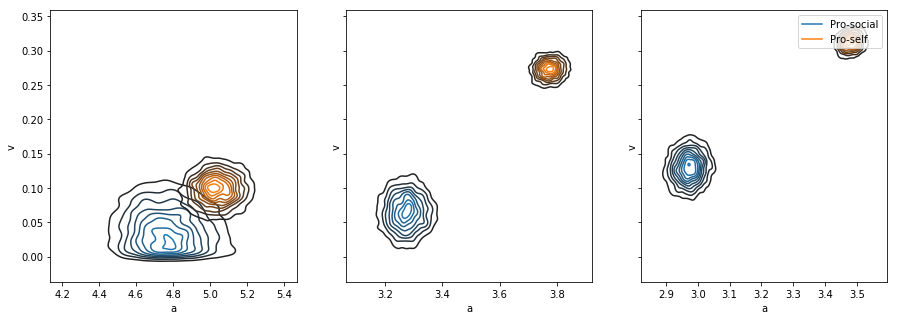

In [21]:
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharey = True)
count = 0
for r in [0,5,9]:
    sns.kdeplot(models_soc_m3[r].get_traces()["a"], np.abs(models_soc_m3[r].get_traces()["v"]), label = "Pro-social", ax=axes[count])
    sns.kdeplot(models_sel_m3[r].get_traces()["a"], np.abs(models_sel_m3[r].get_traces()["v"]),  label = "Pro-self", ax=axes[count])
    count += 1
plt.legend()

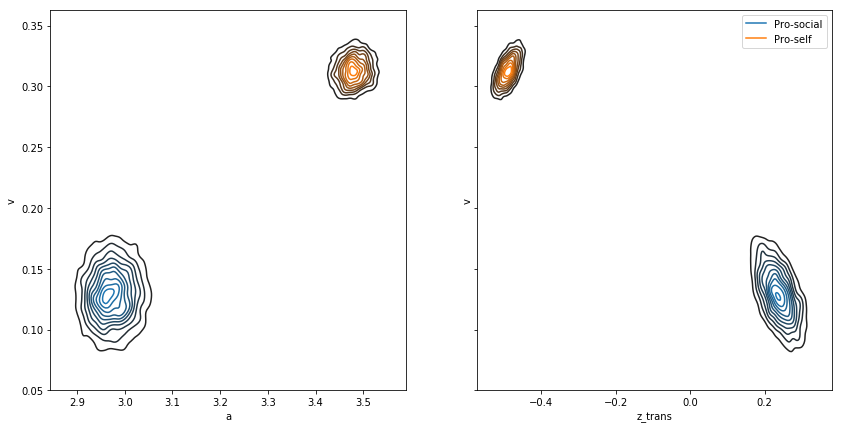

In [22]:
#Plotting parameters for the models

f, axes = plt.subplots(1, 2, figsize=(14, 7), sharey = True)
#plt.figure(figsize = (8,8))
sns.kdeplot(model_soc_m1.get_traces()["a"], np.abs(model_soc_m1.get_traces()["v"]), label = "Pro-social", ax=axes[0])
sns.kdeplot(model_sel_m1.get_traces()["a"], np.abs(model_sel_m1.get_traces()["v"]),  label = "Pro-self", ax=axes[0])

sns.kdeplot(model_soc_m1.get_traces()["z_trans"], np.abs(model_soc_m1.get_traces()["v"]), label = "Pro-social", ax=axes[1])
sns.kdeplot(model_sel_m1.get_traces()["z_trans"], np.abs(model_sel_m1.get_traces()["v"]),  label = "Pro-self", ax=axes[1])
plt.legend()

NameError: name 'model_soc_s1' is not defined

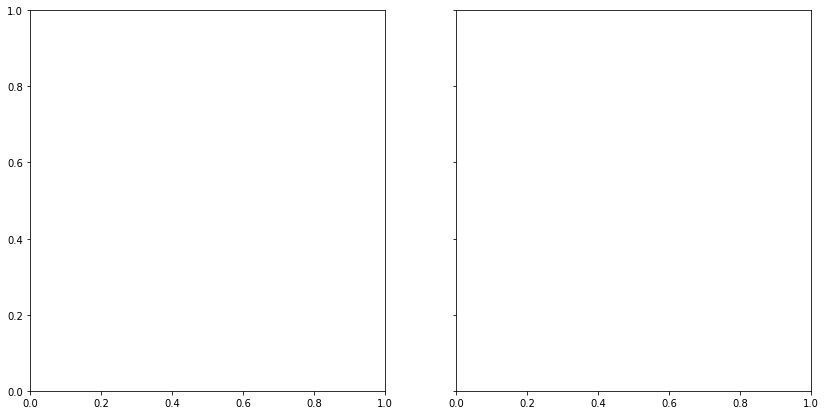

In [23]:
f, axes = plt.subplots(1, 2, figsize=(14, 7), sharey = True)
#plt.figure(figsize = (8,8))
sns.kdeplot(model_soc_s1.get_traces()["a"], np.abs(model_soc_s1.get_traces()["v"]), label = "Pro-social", ax=axes[0])
sns.kdeplot(model_sel_s1.get_traces()["a"], np.abs(model_sel_s1.get_traces()["v"]),  label = "Pro-self", ax=axes[0])

sns.kdeplot(model_soc_s1.get_traces()["z_trans"], np.abs(model_soc_s1.get_traces()["v"]), label = "Pro-social", ax=axes[1])
sns.kdeplot(model_sel_s1.get_traces()["z_trans"], np.abs(model_sel_s1.get_traces()["v"]),  label = "Pro-self", ax=axes[1])
plt.legend()

In [ ]:
sel_dist = modeler.get_stats(model_sel_s1, subjects= True)
sel_dist = sel_dist.loc[sel_dist.subject.notnull()]
soc_dist = modeler.get_stats(model_soc_s1, subjects= True)
soc_dist = soc_dist.loc[soc_dist.subject.notnull()]
soc_dist

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(14, 7), sharey = True)
#plt.figure(figsize = (8,8))
sns.kdeplot(soc_dist.loc[soc_dist.param == "a"]["mean"], soc_dist.loc[soc_dist.param == "v"]["mean"], label = "Pro-social", ax=axes[0])
sns.kdeplot(sel_dist.loc[sel_dist.param == "a"]["mean"], sel_dist.loc[sel_dist.param == "v"]["mean"], label = "Pro-self", ax=axes[0])

sns.kdeplot(soc_dist.loc[soc_dist.param == "z"]["mean"], soc_dist.loc[soc_dist.param == "v"]["mean"], label = "Pro-social", ax=axes[1])
sns.kdeplot(sel_dist.loc[sel_dist.param == "z"]["mean"], sel_dist.loc[sel_dist.param == "v"]["mean"], label = "Pro-self", ax=axes[1])
axes[0].set_xlabel("a")
axes[1].set_xlabel("z")
axes[0].set_ylabel("v")
axes[1].set_ylabel("v")
plt.legend()

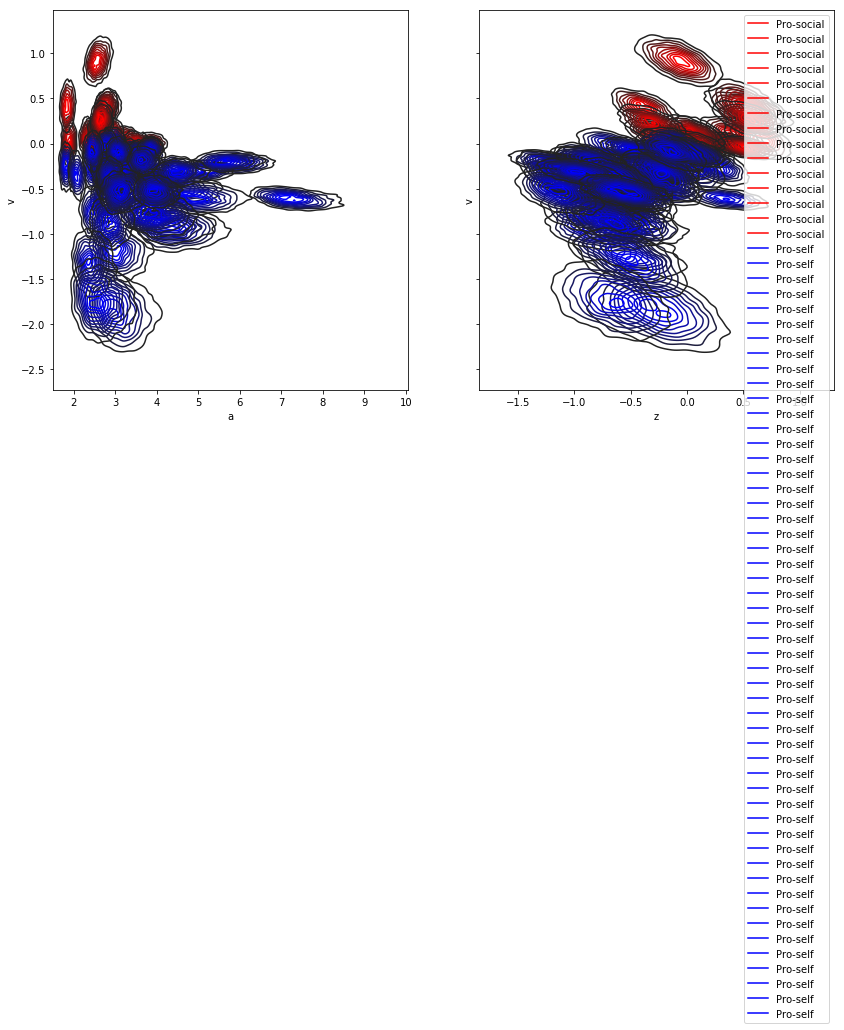

In [25]:
f, axes = plt.subplots(1, 2, figsize=(14, 7), sharey = True)
for m in models_soc_s2:
    sns.kdeplot(m.get_traces()["a"], m.get_traces()["v"], label = "Pro-social", ax=axes[0], color = "r")
    sns.kdeplot(m.get_traces()["z_trans"], m.get_traces()["v"], label = "Pro-social", ax=axes[1], color = "r")
for s in models_sel_s2:
    sns.kdeplot(s.get_traces()["a"], s.get_traces()["v"], label = "Pro-self", ax=axes[0], color = "b")
    sns.kdeplot(s.get_traces()["z_trans"], s.get_traces()["v"], label = "Pro-self", ax=axes[1], color = "b")
#sns.kdeplot(stats_soc_s2.loc[stats_soc_s2.parameter == "a"]["mean"], stats_soc_s2.loc[stats_soc_s2.parameter == "v"]["mean"], label = "Pro-social", ax=axes[0])
#sns.kdeplot(stats_sel_s2.loc[stats_sel_s2.parameter == "a"]["mean"], stats_sel_s2.loc[stats_sel_s2.parameter == "v"]["mean"], label = "Pro-self", ax=axes[0])

#sns.kdeplot(stats_soc_s2.loc[stats_soc_s2.parameter == "z"]["mean"], stats_soc_s2.loc[stats_soc_s2.parameter == "v"]["mean"], label = "Pro-social", ax=axes[1])
#sns.kdeplot(stats_sel_s2.loc[stats_sel_s2.parameter == "z"]["mean"], stats_sel_s2.loc[stats_sel_s2.parameter == "v"]["mean"], label = "Pro-self", ax=axes[1])
axes[0].set_xlabel("a")
axes[1].set_xlabel("z")
axes[0].set_ylabel("v")
axes[1].set_ylabel("v")
plt.legend()

In [26]:
test_subjects = actions.loc[actions.user.isin(test_chang.player.unique()), ["user", "type"]]
test_subjects["predicted100"] = ""

for t in test_chang.player.unique():
    test_df = test_chang.loc[test_chang.player == t]
    model_test_100 = modeler.fit_model(test_df, 5000, 200)
    dist_soc = distance.euclidean(model_test_100.gen_stats()["mean"], model_soc_m1.gen_stats()["mean"])
    dist_self = distance.euclidean(model_test_100.gen_stats()["mean"], model_sel_m1.gen_stats()["mean"])
    pred = ""
    if dist_soc > dist_self:
        pred = "Pro-self"
    else:
        pred = "Pro-social"
    print("Self: %f, social: %f, pred: %s" % (dist_self, dist_soc, pred))
    test_subjects.loc[test_subjects.user == t, "predicted100"] = pred

 [-----------------100%-----------------] 5000 of 5000 complete in 4.8 secSelf: 1.749886, social: 1.296874, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 7.9 secSelf: 1.753976, social: 2.326226, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 6.4 secSelf: 0.389364, social: 0.431734, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 6.1 secSelf: 0.975297, social: 0.586997, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 5.1 secSelf: 0.820466, social: 1.371795, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 5.6 secSelf: 0.981039, social: 0.535266, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 4.2 secSelf: 0.546075, social: 0.595369, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 5.6 secSelf: 0.335936, social: 0.723049, pred: Pro-self
 [--------

In [27]:
test_subjects

,user,type,predicted100
79,s5m20_usuario4,Pro-self,Pro-social
86,s5m20_usuario11,Pro-self,Pro-self
92,s5m20_usuario17,Pro-social,Pro-self
93,s5m20_usuario18,Pro-self,Pro-social
95,s6m22_usuario2,Pro-self,Pro-self
97,s6m22_usuario4,Pro-social,Pro-social
98,s6m22_usuario5,Pro-self,Pro-self
100,s6m22_usuario7,Pro-self,Pro-self
101,s6m22_usuario8,Pro-social,Pro-social
103,s6m22_usuario10,Pro-self,Pro-social


In [28]:
test_subjects["predicted50"] = ""

for t in test_chang.player.unique():
    test_df = test_chang.loc[(test_chang.player == t) & (test_chang["round"] <= 50)]
    model_test = modeler.fit_model(test_df, 5000, 200)
    dist_soc = distance.euclidean(model_test.gen_stats()["mean"], model_soc_m1.gen_stats()["mean"])
    dist_self = distance.euclidean(model_test.gen_stats()["mean"], model_sel_m1.gen_stats()["mean"])
    pred = ""
    if dist_soc > dist_self:
        pred = "Pro-self"
    else:
        pred = "Pro-social"
    print("Self: %f, social: %f, pred: %s" % (dist_self, dist_soc, pred))
    test_subjects.loc[test_subjects.user == t, "predicted50"] = pred

 [-----------------100%-----------------] 5000 of 5000 complete in 4.3 secSelf: 1.805398, social: 1.319031, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 8.9 secSelf: 1.981179, social: 2.533214, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 7.9 secSelf: 0.425769, social: 0.567384, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 6.5 secSelf: 1.154338, social: 0.900235, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 4.5 secSelf: 1.147361, social: 1.387028, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 6.7 secSelf: 0.824068, social: 0.559122, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 4.1 secSelf: 0.479794, social: 0.512626, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 7.0 secSelf: 0.373096, social: 0.780056, pred: Pro-self
 [--------

In [29]:
test_subjects["predicted20"] = ""

for t in test_chang.player.unique():
    test_df = test_chang.loc[(test_chang.player == t) & (test_chang["round"] <= 20)]
    model_test = modeler.fit_model(test_df, 5000, 200)
    dist_soc = distance.euclidean(model_test.gen_stats()["mean"], model_soc_m1.gen_stats()["mean"])
    dist_self = distance.euclidean(model_test.gen_stats()["mean"], model_sel_m1.gen_stats()["mean"])
    pred = ""
    if dist_soc > dist_self:
        pred = "Pro-self"
    else:
        pred = "Pro-social"
    print("Self: %f, social: %f, pred: %s" % (dist_self, dist_soc, pred))
    test_subjects.loc[test_subjects.user == t, "predicted20"] = pred

 [-----------------100%-----------------] 5000 of 5000 complete in 4.9 secSelf: 1.665975, social: 1.196217, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 8.7 secSelf: 1.741322, social: 2.276864, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 10.6 secSelf: 1.282234, social: 1.709538, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 12.7 secSelf: 1.051247, social: 1.032899, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 6.3 secSelf: 0.881905, social: 1.224614, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 11.6 secSelf: 0.583968, social: 0.840095, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 5.7 secSelf: 0.471673, social: 0.963237, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 8.4 secSelf: 0.608100, social: 1.093547, pred: Pro-self
 [-------

In [30]:
test_subjects["predicted10"] = ""

for t in test_chang.player.unique():
    test_df = test_chang.loc[(test_chang.player == t) & (test_chang["round"] <= 20) & (test_chang["round"] > 10)]
    model_test = modeler.fit_model(test_df, 5000, 200)
    dist_soc = distance.euclidean(model_test.gen_stats()["mean"], models_soc_m2[0].gen_stats()["mean"])
    dist_self = distance.euclidean(model_test.gen_stats()["mean"], models_sel_m2[0].gen_stats()["mean"])
    pred = ""
    if dist_soc > dist_self:
        pred = "Pro-self"
    else:
        pred = "Pro-social"
    print("Self: %f, social: %f, pred: %s" % (dist_self, dist_soc, pred))
    test_subjects.loc[test_subjects.user == t, "predicted10"] = pred

 [-----------------100%-----------------] 5000 of 5000 complete in 5.7 secSelf: 3.320620, social: 3.055791, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 9.3 secSelf: 0.704809, social: 0.974367, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 9.0 secSelf: 2.709494, social: 2.423062, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 13.3 secSelf: 1.968291, social: 1.709344, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 5.0 secSelf: 3.065061, social: 2.896179, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 10.1 secSelf: 1.515203, social: 1.253399, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 5.8 secSelf: 2.028770, social: 1.783443, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 7.7 secSelf: 1.835043, social: 1.577848, pred: Pro-social


In [31]:
test_subjects["predicted1020_m2"] = ""

for t in test_chang.player.unique():
    test_df = test_chang.loc[(test_chang.player == t) & (test_chang["round"] <= 20) & (test_chang["round"] > 10)]
    model_test = modeler.fit_model(test_df, 5000, 200)
    dist_soc = distance.euclidean(model_test.gen_stats()["mean"], models_soc_m2[1].gen_stats()["mean"])
    dist_self = distance.euclidean(model_test.gen_stats()["mean"], models_sel_m2[1].gen_stats()["mean"])
    pred = ""
    if dist_soc > dist_self:
        pred = "Pro-self"
    else:
        pred = "Pro-social"
    print("Self: %f, social: %f, pred: %s" % (dist_self, dist_soc, pred))
    test_subjects.loc[test_subjects.user == t, "predicted1020_m2"] = pred

 [-----------------100%-----------------] 5000 of 5000 complete in 6.0 secSelf: 2.383991, social: 1.777872, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 9.7 secSelf: 1.607496, social: 2.265084, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 10.5 secSelf: 2.149823, social: 1.604798, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 14.5 secSelf: 1.057006, social: 0.646724, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 5.6 secSelf: 2.135455, social: 1.944276, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 13.0 secSelf: 0.636127, social: 0.375920, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 7.4 secSelf: 1.077366, social: 0.574452, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 8.8 secSelf: 0.913541, social: 0.410483, pred: Pro-social

In [32]:
test_subjects["predicted20_m3"] = ""

for t in test_chang.player.unique():
    test_df = test_chang.loc[(test_chang.player == t) & (test_chang["round"] <= 20)]
    model_test = modeler.fit_model(test_df, 5000, 200)
    dist_soc = distance.euclidean(model_test.gen_stats()["mean"], models_soc_m3[1].gen_stats()["mean"])
    dist_self = distance.euclidean(model_test.gen_stats()["mean"], models_sel_m3[1].gen_stats()["mean"])
    pred = ""
    if dist_soc > dist_self:
        pred = "Pro-self"
    else:
        pred = "Pro-social"
    print("Self: %f, social: %f, pred: %s" % (dist_self, dist_soc, pred))
    test_subjects.loc[test_subjects.user == t, "predicted20_m3"] = pred

 [-----------------100%-----------------] 5000 of 5000 complete in 5.7 secSelf: 2.737337, social: 2.321987, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 9.9 secSelf: 0.655155, social: 1.107790, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 11.9 secSelf: 0.481819, social: 0.638920, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 13.0 secSelf: 1.752238, social: 1.441456, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 5.7 secSelf: 1.815478, social: 1.611203, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 11.5 secSelf: 1.065903, social: 0.712892, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 5.7 secSelf: 0.757276, social: 0.384179, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 8.7 secSelf: 0.691546, social: 0.420140, pred: Pro-social
 

In [33]:
test_subjects

,user,type,predicted100,predicted50,predicted20,predicted10,predicted1020_m2,predicted20_m3
79,s5m20_usuario4,Pro-self,Pro-social,Pro-social,Pro-social,Pro-social,Pro-social,Pro-social
86,s5m20_usuario11,Pro-self,Pro-self,Pro-self,Pro-self,Pro-self,Pro-self,Pro-self
92,s5m20_usuario17,Pro-social,Pro-self,Pro-self,Pro-self,Pro-social,Pro-social,Pro-self
93,s5m20_usuario18,Pro-self,Pro-social,Pro-social,Pro-social,Pro-social,Pro-social,Pro-social
95,s6m22_usuario2,Pro-self,Pro-self,Pro-self,Pro-self,Pro-social,Pro-social,Pro-social
97,s6m22_usuario4,Pro-social,Pro-social,Pro-social,Pro-self,Pro-social,Pro-social,Pro-social
98,s6m22_usuario5,Pro-self,Pro-self,Pro-self,Pro-self,Pro-social,Pro-social,Pro-social
100,s6m22_usuario7,Pro-self,Pro-self,Pro-self,Pro-self,Pro-social,Pro-social,Pro-social
101,s6m22_usuario8,Pro-social,Pro-social,Pro-social,Pro-social,Pro-social,Pro-social,Pro-social
103,s6m22_usuario10,Pro-self,Pro-social,Pro-social,Pro-self,Pro-social,Pro-social,Pro-social


In [239]:
soc_dist.loc[(soc_dist.subject == "s10n5_usuario3") & (soc_dist.param.isin(["a", "v", "t", "z"]))]["mean"].values

array([3.0173368180728706, 0.8114865167806177, 0.48790055533133303,
       0.7375558785063352], dtype=object)

In [163]:
subj_params = []
for subj_idx, subj_data in train_fix.groupby('player'):
    m_subj = hddm.HDDM(subj_data, bias = True)
    params_dict = m_subj.optimize('chisquare')
    params_dict["subject"] = subj_idx
    subj_params.append(params_dict)
params = pd.DataFrame(subj_params)

Optimization terminated successfully.
         Current function value: 18.454725
         Iterations: 10
         Function evaluations: 655
Optimization terminated successfully.
         Current function value: 18.454728
         Iterations: 8
         Function evaluations: 567
Optimization terminated successfully.
         Current function value: 18.454718
         Iterations: 8
         Function evaluations: 468
Optimization terminated successfully.
         Current function value: 20.369408
         Iterations: 7
         Function evaluations: 441
Optimization terminated successfully.
         Current function value: 20.369443
         Iterations: 4
         Function evaluations: 232
Optimization terminated successfully.
         Current function value: 20.369421
         Iterations: 8
         Function evaluations: 529
Optimization terminated successfully.
         Current function value: 10.807699
         Iterations: 9
         Function evaluations: 545
Optimization terminated su

Optimization terminated successfully.
         Current function value: 7266.668158
         Iterations: 6
         Function evaluations: 696
Optimization terminated successfully.
         Current function value: 30.121776
         Iterations: 11
         Function evaluations: 706
Optimization terminated successfully.
         Current function value: 30.121711
         Iterations: 18
         Function evaluations: 1004
Optimization terminated successfully.
         Current function value: 30.121742
         Iterations: 9
         Function evaluations: 579
Optimization terminated successfully.
         Current function value: 41.648680
         Iterations: 5
         Function evaluations: 289
Optimization terminated successfully.
         Current function value: 41.648806
         Iterations: 5
         Function evaluations: 281
Optimization terminated successfully.
         Current function value: 41.648731
         Iterations: 7
         Function evaluations: 456
Optimization terminate

Optimization terminated successfully.
         Current function value: 14.574199
         Iterations: 8
         Function evaluations: 516
Optimization terminated successfully.
         Current function value: 14.574197
         Iterations: 9
         Function evaluations: 566


In [188]:
s1_params = params.merge(actions[["type", "user"]], left_on = "subject", right_on = "user")
s1_params

,a,v,t,z_trans,z,subject,type,user
0,4.158109,-0.254604,3.148245e-02,-0.652310,0.342469,s10n5_usuario1,Pro-self,s10n5_usuario1
1,2.989481,-0.123384,6.668015e-01,-0.229806,0.442800,s10n5_usuario2,Pro-self,s10n5_usuario2
2,2.531977,0.773984,4.984520e-01,0.895961,0.710119,s10n5_usuario3,Pro-social,s10n5_usuario3
3,3.838329,0.616670,2.456834e-01,0.647144,0.656367,s10n5_usuario4,Pro-social,s10n5_usuario4
4,1.882096,-0.168790,3.285496e-01,-0.517201,0.373507,s10n5_usuario7,Pro-self,s10n5_usuario7
5,1.826603,0.443384,3.337972e-01,-0.027081,0.493230,s10n5_usuario8,Pro-social,s10n5_usuario8
6,2.703833,0.138398,3.313232e-01,0.295886,0.573436,s4m8_usuario1,Pro-social,s4m8_usuario1
7,18.710461,1.550441,6.136000e-03,0.428858,0.605601,s4m8_usuario10,Pro-social,s4m8_usuario10
8,5.237835,-0.010463,5.112860e-01,0.902658,0.711495,s4m8_usuario11,Pro-social,s4m8_usuario11
9,4.374724,1.617594,3.375194e+00,-0.609631,0.352143,s4m8_usuario12,Pro-social,s4m8_usuario12


In [249]:
for t in test_fix.player.unique():
    test_df = test_fix.loc[(test_fix.player == t)]
    model_test = modeler.fit_model(test_df, 5000, 200)
    test_vals = model_test.gen_stats()["mean"].values
    dist_soc = []
    for s in soc_dist.subject.unique():
        vals = soc_dist.loc[(soc_dist.subject == s) & (soc_dist.param.isin(["a", "v", "t", "z"]))]["mean"].values
        dist_soc.append(distance.euclidean(test_vals, vals))
    dist_sel = []
    for s in sel_dist.subject.unique():
        vals = sel_dist.loc[(sel_dist.subject == s) & (sel_dist.param.isin(["a", "v", "t", "z"]))]["mean"].values
        dist_sel.append(distance.euclidean(test_vals, vals))
    pred = ""
    if np.mean(dist_soc) > np.mean(dist_sel):
        pred = "Pro-self"
    else:
        pred = "Pro-social"
    print("soc %f sel %f pred: %s" % (np.mean(dist_soc),np.mean(dist_sel), pred))
    test_subjects.loc[test_subjects.user == t, "predicted20"] = pred

 [-----------------100%-----------------] 5000 of 5000 complete in 5.7 secsoc 2.302357 sel 1.335696 pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 6.6 secsoc 2.153125 sel 1.070257 pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 9.4 secsoc 2.007644 sel 1.118550 pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 5.8 secsoc 2.012799 sel 1.823979 pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 4.8 secsoc 2.662781 sel 2.173334 pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 5.0 secsoc 2.237887 sel 1.593814 pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 4.5 secsoc 2.823496 sel 2.196032 pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 5.8 secsoc 1.892094 sel 1.357997 pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 7.5 secsoc 2.